In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_validate
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

#We may want these at some point for transforming our output:
#from scipy.special import logit, expit

pd.set_option('display.max_columns', None) #forces all columns to be displayed
pd.set_option('display.max_rows', None) #forces all rows to be displayed

In [19]:
filepath = r'../data/data-reduced-train.csv'
data = pd.read_csv(filepath)

In [20]:
'''#split data based on thresholds
percent_asian_threshold = 5
percent_black_threshold = 10
percent_hispanic_threshold = 10
percent_white_threshold = 50

high_asian_counties = data[data['% Asian'] >= percent_asian_threshold]
high_black_counties = data[data['% Black'] >= percent_black_threshold]
high_hispanic_counties = data[data['% Hispanic'] >= percent_hispanic_threshold]
high_white_counties = data[data['% Non-Hispanic White'] >= percent_white_threshold]

race_splits = {#'High Asian Counties': high_asian_counties,
               'High Black Counties': high_black_counties,
               'High Hispanic Counties': high_hispanic_counties,
               'High White Counties': high_white_counties}'''
print()

In [21]:
print(data['% Asian'].median())
print(data['% Black'].median())
print(data['% Hispanic'].median())
print(data['% Non-Hispanic White'].median())

0.8228077475
2.3496015596
5.1144083918
82.017880124


In [22]:
percent_white_median = data['% Non-Hispanic White'].median()

In [23]:
supermedian_white_counties = data[data['% Non-Hispanic White'] > percent_white_median]
submedian_white_counties = data[data['% Non-Hispanic White'] <= percent_white_median]

In [24]:
%run ../data/features-grouped.ipynb
%run ../data/model-information.ipynb

In [25]:
# extract_feature_names_by_cateogry appears in features-grouped.ipynb, called above
# features_by_category is a dictionary from the same file

health_behaviors_features = extract_feature_names_by_category(data, features_by_category['Health Behaviors']) 
access_to_care_features = extract_feature_names_by_category(data, features_by_category['Access to Care'])
socio_economic_features = extract_feature_names_by_category(data, features_by_category['Socio-economic Factors'])
physical_environment_features = extract_feature_names_by_category(data, features_by_category['Physical Environment'])
demographics_features = extract_feature_names_by_category(data, features_by_category['Demographics'])

all_features = data.columns[4:].to_list()

target = data.columns[3] #'% Adults with Diabetes'

In [26]:
#The 'Parameters' in this dictionary are dictionaries from model-information.ipynb, imported above

model_features_and_parameters = {
    "Model 1 (All Features)": {'Features': all_features, 'Parameters': xgb_best_params_full},
    "Model 2 (Health Behaviors)": {'Features': health_behaviors_features, 'Parameters': xgb_best_params_health},
    "Model 3 (Access to Care)": {'Features': access_to_care_features, 'Parameters': xgb_best_params_care},
    "Model 4 (Socio-economic Factors)": {'Features': socio_economic_features, 'Parameters': xgb_best_params_socioecon},
    "Model 5 (Physical Environment)": {'Features': physical_environment_features, 'Parameters': xgb_best_params_environment},
    "Model 6 (Demographics)": {'Features': demographics_features, 'Parameters': xgb_best_params_demographic}
}

### Run XGB with optimized hyperparameters on the counties with white population above the median

In [27]:
df = supermedian_white_counties.copy()
df_train, df_val = train_test_split(df, test_size=0.1, random_state=42)

def model_rmse(model, df, features, target):
    model_preds = model.predict(df[features])
    return root_mean_squared_error(df[target], model_preds)

features = all_features
params = xgb_best_params_full
n_neighbors = 10 #neighbors for kNN imputation
xgb_pipe = Pipeline([('impute', KNNImputer(n_neighbors=n_neighbors)),
                     ('xgb', XGBRegressor(**params))])

xgb_pipe.fit(df_train[features], df_train[target])

train_rmse = float(model_rmse(xgb_pipe, df_train, features, target))
val_rmse = float(model_rmse(xgb_pipe, df_val, features, target))

print(f'Training RMSE: {train_rmse:.4f}')
print(f'Validation RMSE: {val_rmse:.4f}')

Training RMSE: 0.1732
Validation RMSE: 0.4052


### Feature Importances from this model

In [ ]:
category_colors = {
    "Health Behaviors": "skyblue",
    "Access to Care": "lightcoral",
    "Socio-economic Factors": "gold",
    "Physical Environment": "lightpink",
    "Demographics": "lightseagreen"
}

feature_to_category = {}
for category, features in features_by_category.items():
    for feature in features:
        feature_to_category[feature] = category

In [ ]:
'''importance_bottom_50 = feature_importance(feature_bottom_50)

# Map each feature to its category
importance_bottom_50['Category'] = importance_bottom_50['Feature'].map(feature_to_category)

# Assign colors based on the mapped categories
importance_bottom_50['Color'] = importance_bottom_50['Category'].map(category_colors)

num_features = importance_bottom_50.shape[0]
plt.figure(figsize=(12, max(8, num_features * 0.2))) 

# Number of top features to display
top_n = 15
top_features = importance_bottom_50.tail(top_n)['Feature'].values
top_importance = importance_bottom_50.tail(top_n)['Importance'].values
feature_colors_top = importance_bottom_50.tail(top_n)['Color'].values

bars = plt.barh(top_features, top_importance, color=feature_colors_top)

plt.xlabel('Feature Importance')
plt.title('Feature Importances Low Income')

# Create a legend for the categories
legend_elements = [
    Patch(facecolor=color, edgecolor='gray', label=category)
    for category, color in category_colors.items()
]

plt.legend(handles=legend_elements, title='Feature Categories', loc='lower right')
plt.tight_layout()
plt.show()'''

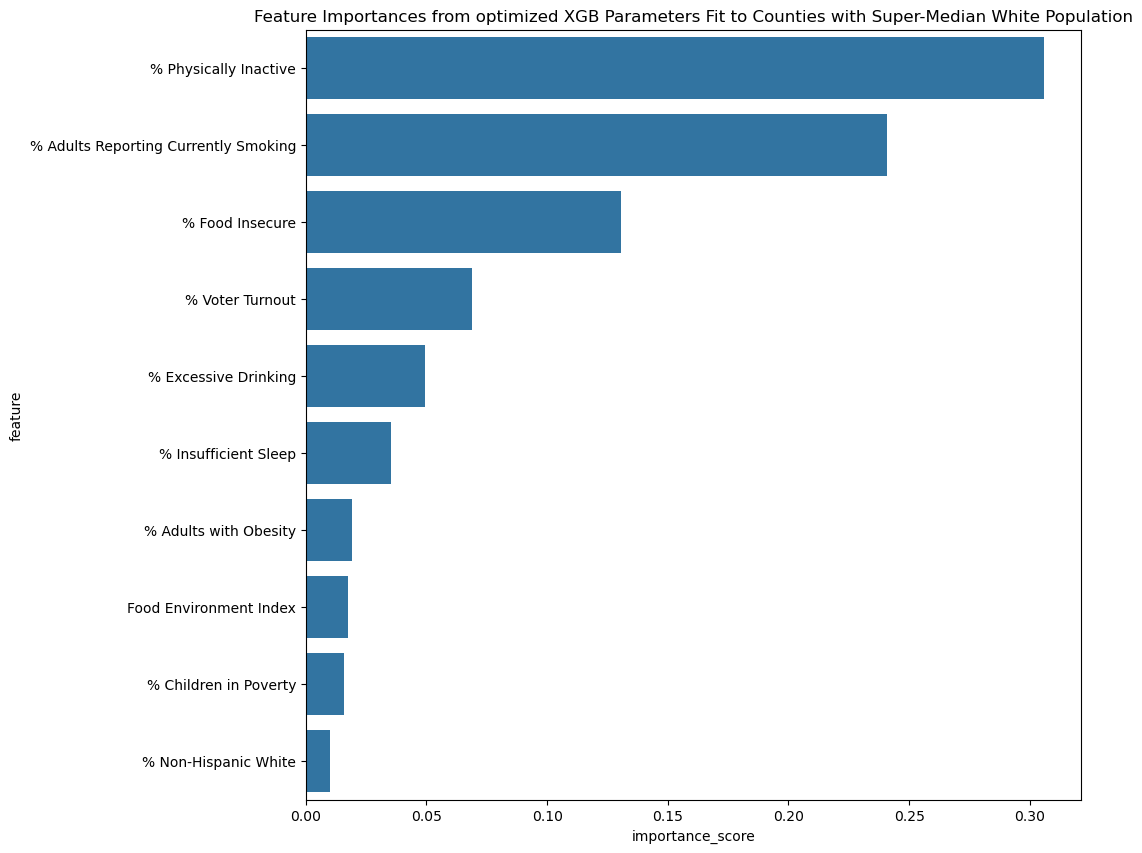

In [28]:
#data frame matching features with their importances computed from xgboost
top_10_xgb_importances = pd.DataFrame({'feature': features,
                               'importance_score': xgb_pipe['xgb'].feature_importances_})\
                                .sort_values(by='importance_score', ascending=False)[:10]

plt.figure(figsize=(10,10))
plt.title("Feature Importances from optimized XGB Parameters Fit to Counties with Super-Median White Population")
sns.barplot(data=top_10_xgb_importances, y='feature', x='importance_score', orient='h')

plt.show()

### Same parameters fit to the sub-median White population counties

In [30]:
df = submedian_white_counties.copy()
df_train, df_val = train_test_split(df, test_size=0.1, random_state=42)

def model_rmse(model, df, features, target):
    model_preds = model.predict(df[features])
    return root_mean_squared_error(df[target], model_preds)

features = all_features
params = xgb_best_params_full
n_neighbors = 10 #neighbors for kNN imputation
xgb_pipe = Pipeline([('impute', KNNImputer(n_neighbors=n_neighbors)),
                     ('xgb', XGBRegressor(**params))])

xgb_pipe.fit(df_train[features], df_train[target])

train_rmse = float(model_rmse(xgb_pipe, df_train, features, target))
val_rmse = float(model_rmse(xgb_pipe, df_val, features, target))

print(f'Training RMSE: {train_rmse:.4f}')
print(f'Validation RMSE: {val_rmse:.4f}')

Training RMSE: 0.2340
Validation RMSE: 0.5944


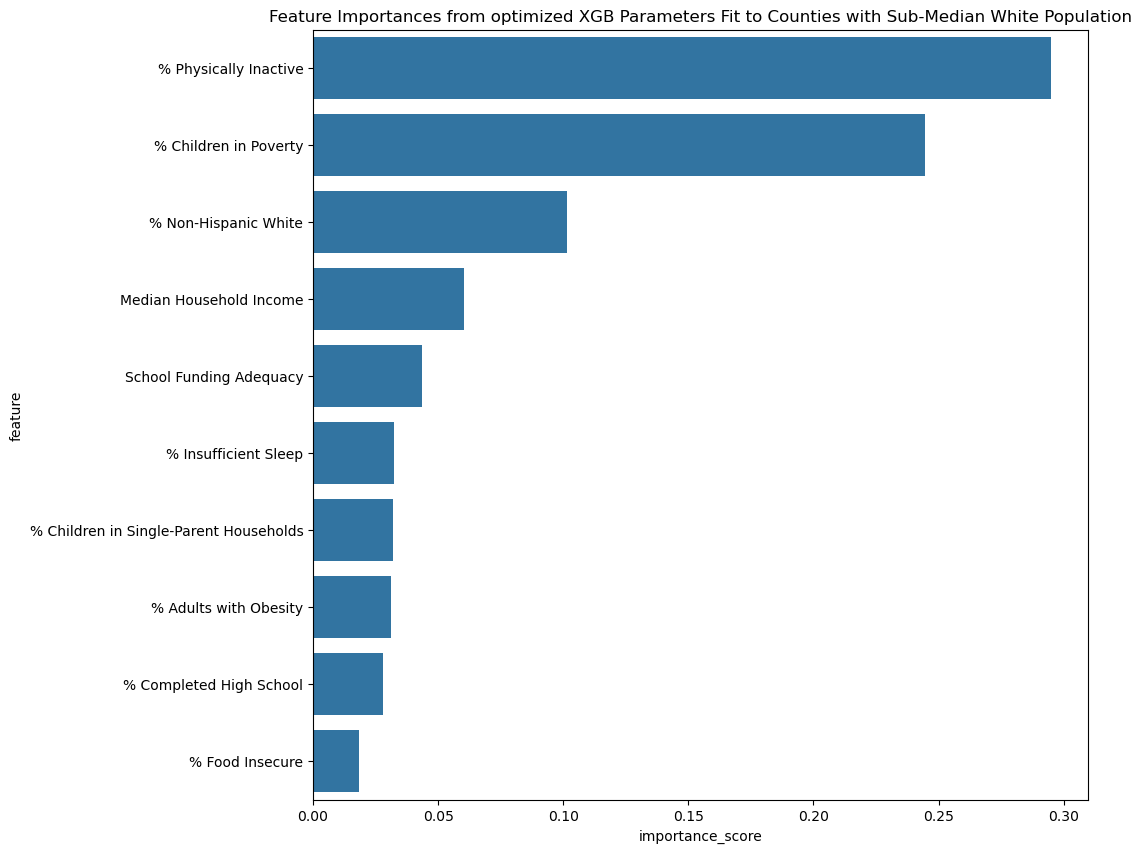

In [31]:
#data frame matching features with their importances computed from xgboost
top_10_xgb_importances = pd.DataFrame({'feature': features,
                               'importance_score': xgb_pipe['xgb'].feature_importances_})\
                                .sort_values(by='importance_score', ascending=False)[:10]

plt.figure(figsize=(10,10))
plt.title("Feature Importances from optimized XGB Parameters Fit to Counties with Sub-Median White Population")
sns.barplot(data=top_10_xgb_importances, y='feature', x='importance_score', orient='h')

plt.show()

In [ ]:
#future code to run more models on more race splits and with other subsets of features

'''

def model_error(model, df, features, target):
    model_preds = model.predict(df[features])
    return root_mean_squared_error(df[target], model_preds)

results = {}
fitted_models = {}

for race_split, df in race_splits.items():
    #split data into train/val sets
    df_train, df_val = train_test_split(df,test_size=0.1, random_state=42)

    for model_name, model_info in model_features_and_parameters.items():
        features = model_info['Features']         #list of features for feature subset model
        parameters = model_info['Parameters']     #dict of best parameters for the model

        #instantiate model(s)
        xgb_pipe = Pipeline([('impute', KNNImputer(n_neighbors=n_neighbors)),
                     ('xgb', XGBRegressor(**parameters))])
    
        #fit model(s) to train set
        #xgb_pipe.fit(df_train[features], df_train[target])

        #Compute and store training RMSEs
        #training_rmses['Training RMSE on ' + key] = model_error(xgb_pipe, df_train, features, target)
        #Compute and store validation RMSEs
        #val_rmses['Validation RMSE on ' + key] = model_error(xgb_pipe, )



#linear_pipe
#baseline models
#RFC?'''

In [ ]:
#plot feature importances